# HW5_autoregressive_models_with_statsmodels_1
In this project, we focus on 'AutoReg' and 'ar_select_order' from statsmodels library to develope autoregressive models for time series data.

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sn
import pandas_datareader as pdr
from statsmodels.tsa.api import acf, graphics, pacf
from statsmodels.tsa.ar_model import AutoReg, ar_select_order
from statsmodels.tsa.deterministic import DeterministicProcess

## 1. Data Extraction and Preparation
Extracting the data of 'New Privately-Owned Housing Units Started: Total Units' from one of the remote data sources of pandas_datareader.

This source is "FRED", available on https://fred.stlouisfed.org/ 

Dataset webpage link: https://fred.stlouisfed.org/series/HOUSTNSA

In [2]:
data_full_1 = pdr.get_data_fred("HOUSTNSA", "1959-01-01", "2022-06-01")  
data_full_1.head(4)

,HOUSTNSA
DATE,
1959-01-01,96.2
1959-02-01,99.0
1959-03-01,127.7
1959-04-01,150.8


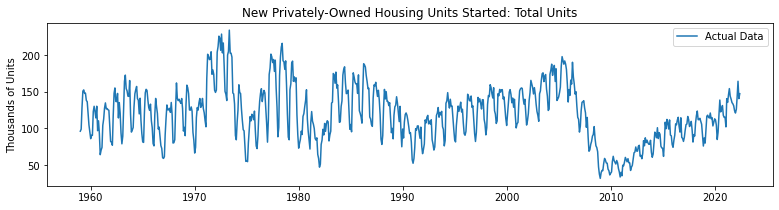

In [3]:
# plotting the main data
plt.figure(figsize=(13,3))
plt.plot(data_full_1['HOUSTNSA'], label="Actual Data")
plt.title('New Privately-Owned Housing Units Started: Total Units')
plt.ylabel('Thousands of Units')
plt.legend()
plt.show()

We calculate the percentage change of the data so that we can have a cyclic data with no trend:

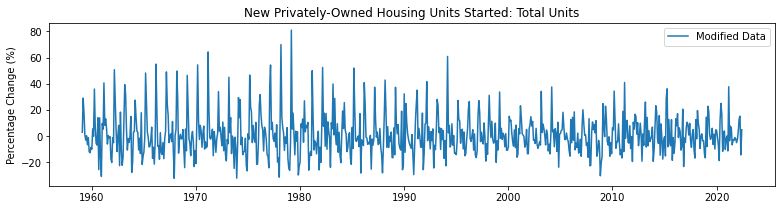

In [4]:
data_1 = data_full_1['HOUSTNSA'].pct_change().dropna() # pct_change: Percentage change between the current and a prior element.
                                                       # pct_change(12): Percentage change between the current and 12th prior element.
data_1 = 100 * data_1.asfreq(freq='MS') # DataFrame.asfreq: Convert time series to specified frequency

# plotting the main data
plt.figure(figsize=(13,3))
plt.plot(data_1, label='Modified Data')
plt.title('New Privately-Owned Housing Units Started: Total Units')
plt.ylabel('Percentage Change (%)')
plt.legend()
plt.show()

## 2. Autoregressive Models
### 2.1. AR Model with Known order number
We assume that the value of each data point can be modeled based on the 4 previous values. So, we develope an AR(4) model as the first step to be able to compare the results. 

In [5]:
model1 = AutoReg(endog=data_1, lags=4).fit()
print(model1.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:                     AutoReg(4)   Log Likelihood               -3111.807
Method:               Conditional MLE   S.D. of innovations             14.758
Date:                Wed, 24 Aug 2022   AIC                           6235.614
Time:                        22:25:10   BIC                           6263.390
Sample:                    06-01-1959   HQIC                          6246.312
                         - 06-01-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.3994      0.541      2.585      0.010       0.338       2.461
HOUSTNSA.L1     0.1424      0.035      4.015      0.000       0.073       0.212
HOUSTNSA.L2     0.0050      0.035      0.142    

We can see above, the extracted values of the constant and the coefficients of the 4 lags.

### 2.2. AR Model with Autoselect model order
Now, we implements 'ar_select_order' which selects the best model order number (lags) by itself. The following code selects all the lags up to an optimal lag number. (In the next sections, we show that by using 'glob=True', we can find the best lags by searching among all the combinations of the lags)

In [6]:
ARSO = ar_select_order(endog=data_1, maxlag=20) # evaluates p = 1 to maxlag.
print(f'Final lag numbers are {ARSO.ar_lags}')

Final lag numbers are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13]


Fitting an AR model based on the above lags:

In [7]:
model2 = ARSO.model.fit()
print(model2.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:                    AutoReg(13)   Log Likelihood               -2824.377
Method:               Conditional MLE   S.D. of innovations             10.559
Date:                Wed, 24 Aug 2022   AIC                           5678.755
Time:                        22:25:11   BIC                           5748.016
Sample:                    03-01-1960   HQIC                          5705.446
                         - 06-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            1.4918      0.459      3.252      0.001       0.593       2.391
HOUSTNSA.L1     -0.2667      0.035     -7.635      0.000      -0.335      -0.198
HOUSTNSA.L2     -0.0881      0.031     -2.82

We plot the forecasts (after data point number 'len(data_1)') of the model for a given period in the future: <br>
https://www.statsmodels.org/dev/generated/statsmodels.tsa.ar_model.AutoRegResults.plot_predict.html 

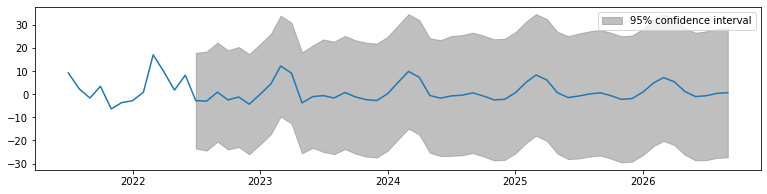

In [8]:
fig1 = model2.plot_predict(start=len(data_1)-12, end=len(data_1)+50, figsize=(13,3))

Now, we show the diagnostic plots for **standardized residuals** (plot_diagnostics([lags, fig, figsize])).<br>
It produces a 2x2 plot grid with the following plots:

- **Standardized residuals over time** (The standardized residual is found by dividing the difference of the observed and expected values by the square root of the expected value. The standardized residual can be interpreted as any standard score. The mean of the standardized residual is 0 and the standard deviation is 1.[1])

- **Histogram plus estimated density of standardized residuals, along with a Normal(0,1) density plotted for reference**

- **Normal Q-Q plot, with Normal reference line** (In statistics, a Q–Q plot (quantile-quantile plot) is a probability plot, a graphical method for comparing two probability distributions by plotting their quantiles against each other. A point (x, y) on the plot corresponds to one of the quantiles of the second distribution (y-coordinate) plotted against the same quantile of the first distribution (x-coordinate).[2])<br>
(First, the data values are ordered and cumulative distribution values are calculated for the ith ordered value out of n total values. A cumulative distribution graph is produced by plotting the ordered data versus the cumulative distribution values. The same process is done for a standard normal distribution (a Gaussian distribution with a mean of 0 and a standard deviation of 1). Once these two cumulative distribution graphs have been generated, data values corresponding to specific quantiles are paired and plotted in a QQ plot.[3]) <br>
![Normal Q-Q Plot](NQQ.png)

- **Correlogram** (In the analysis of data, a correlogram is a chart of correlation statistics. For example, in time series analysis, a plot of the sample autocorrelations versus the time lags is an autocorrelogram.[4])


[1] https://www.cedu.niu.edu/~walker/statistics/Chi%20Square%202.pdf <br>
[2] https://en.wikipedia.org/wiki/Q%E2%80%93Q_plot <br>
[3] https://desktop.arcgis.com/en/arcmap/latest/extensions/geostatistical-analyst/normal-qq-plot-and-general-qq-plot.htm#:~:text=The%20Normal%20QQ%20Plot%20tool,in%20the%20ArcMap%20data%20view. <br>
[4] https://en.wikipedia.org/wiki/Correlogram <br>

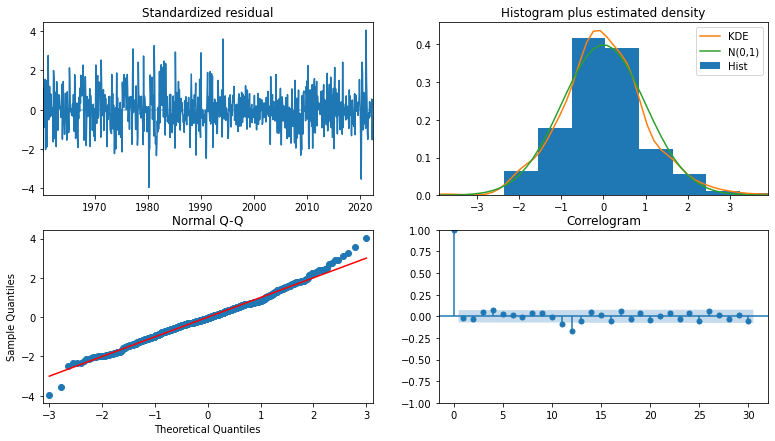

In [9]:
fig2 = model2.plot_diagnostics(lags=30, figsize=(13, 7))

We can see that the model can somewhat capture the dynamics in the data.<br>
More methods for 'AutoReg' in:<br>
https://www.statsmodels.org/devel/generated/statsmodels.tsa.ar_model.AutoRegResults.html 

### 2.3. AR Model with Seasonal Dummies
Deterministic seasonality can be written as a function of seasonal dummy variables. More in [1]. Using the seasonal dummies shortens the dynamics. <br>
[1] https://www.ssc.wisc.edu/~bhansen/390/390Lecture14.pdf

In [10]:
ARSO = ar_select_order(endog=data_1, maxlag=13, seasonal=True)
print(f'Final lag numbers after including seasonal dummies are {ARSO.ar_lags}')

Final lag numbers after including seasonal dummies are [1, 2]


Now, we fit a model:

In [11]:
model3 = ARSO.model.fit()
print(model3.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:               Seas. AutoReg(2)   Log Likelihood               -2807.977
Method:               Conditional MLE   S.D. of innovations              9.783
Date:                Wed, 24 Aug 2022   AIC                           5645.954
Time:                        22:25:15   BIC                           5715.434
Sample:                    04-01-1959   HQIC                          5672.712
                         - 06-01-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.5046      1.360      1.107      0.268      -1.160       4.169
s(2,12)        31.3267      1.819     17.219      0.000      27.761      34.892
s(3,12)        20.0641      2.360      8.501    

As can be seen above, the model includes an intercept, 11 seasonal dummy variables (11 instead of 12 because of considering an intercept), and 2 lags.

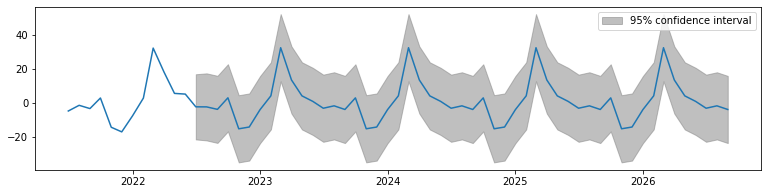

In [12]:
fig1 = model3.plot_predict(start=len(data_1)-12, end=len(data_1)+50, figsize=(13,3))

As can be seen in the above figure, the seasonality in the forecasts is obvious when we compare it to that of model2. <br>
Now, we show the diagnostic plots for the standardized residuals.

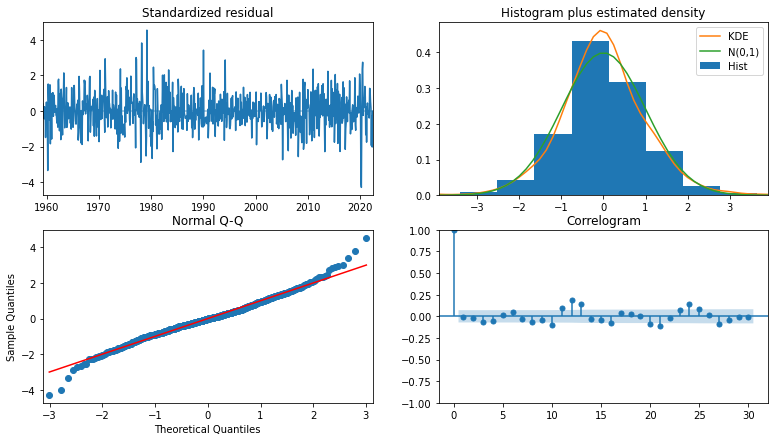

In [13]:
fig2 = model3.plot_diagnostics(lags=30, figsize=(13, 7))

### 2.4. AR Model with Global Search
This time, we use 'glob=True' in order to search among different combinations of the lags since using all the above lags may not be necessary. This may take longer compared to the previous one because it searches among 2^maxlag models. In fact, we use a global search which allows longer lags to enter if needed without requiring the shorter lags. In practice, this option is not computational feasible when maxlag is larger than 15.

In [14]:
ARSO = ar_select_order(endog=data_1, maxlag=13, seasonal=True, glob=True)
print(f'Final lag numbers after including seasonal dummies are {ARSO.ar_lags}')

Final lag numbers after including seasonal dummies are [1, 2, 10, 12, 13]


Now, we fit a model:

In [15]:
model4 = ARSO.model.fit()
print(model4.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  761
Model:             Restr. Seas. AutoReg(13)   Log Likelihood               -2744.761
Method:                     Conditional MLE   S.D. of innovations              9.493
Date:                      Wed, 24 Aug 2022   AIC                           5525.522
Time:                              22:25:35   BIC                           5608.635
Sample:                          03-01-1960   HQIC                          5557.552
                               - 06-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            2.7610      1.402      1.969      0.049       0.012       5.510
s(2,12)         23.9831      2.103     11.406      0.000      19.862      28.

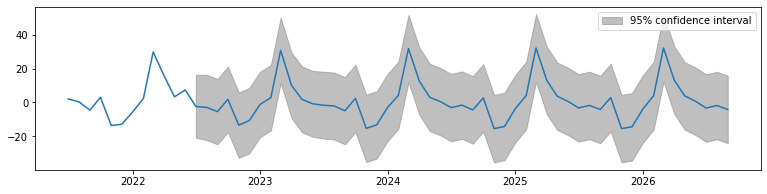

In [16]:
fig1 = model4.plot_predict(start=len(data_1)-12, end=len(data_1)+50, figsize=(13,3))

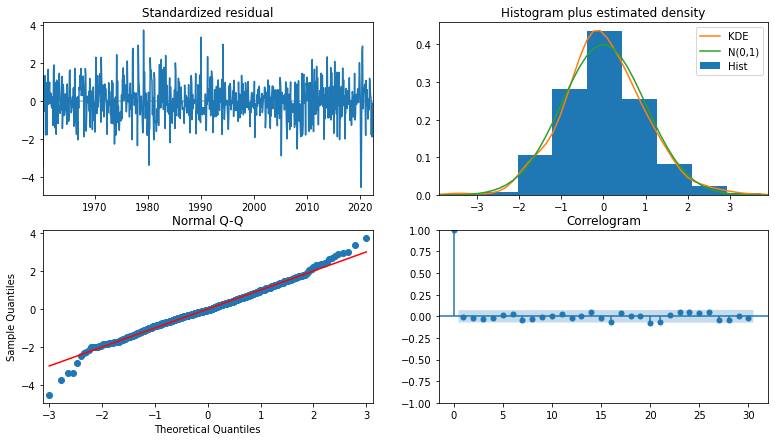

In [17]:
fig2 = model4.plot_diagnostics(lags=30, figsize=(13, 7))

### 2.5. AR Model with Deterministic Process
This allows for more complex deterministic terms to be constructed, for example one that includes seasonal components with two periods, or one that uses a Fourier series rather than seasonal dummies.

In [18]:
dp = DeterministicProcess(data_1.index, constant=True, period=12, fourier=4)
model5 = AutoReg(endog=data_1, lags=4, trend="n", seasonal=False, deterministic=dp).fit()
print(model5.summary())

                            AutoReg Model Results                             
Dep. Variable:               HOUSTNSA   No. Observations:                  761
Model:                     AutoReg(4)   Log Likelihood               -2828.591
Method:               Conditional MLE   S.D. of innovations             10.152
Date:                Wed, 24 Aug 2022   AIC                           5685.183
Time:                        22:25:39   BIC                           5749.994
Sample:                    06-01-1959   HQIC                          5710.145
                         - 06-01-2022                                         
                  coef    std err          z      P>|z|      [0.025      0.975]
-------------------------------------------------------------------------------
const           1.8456      0.384      4.805      0.000       1.093       2.598
sin(1,12)      15.2315      0.895     17.016      0.000      13.477      16.986
cos(1,12)       2.9071      0.903      3.221    

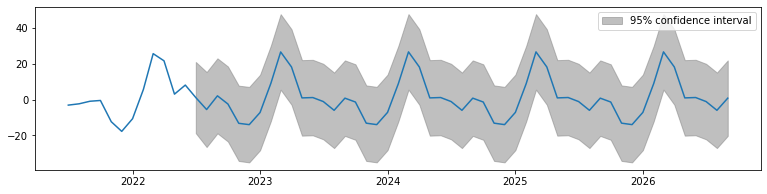

In [19]:
fig1 = model5.plot_predict(start=len(data_1)-12, end=len(data_1)+50, figsize=(13,3))

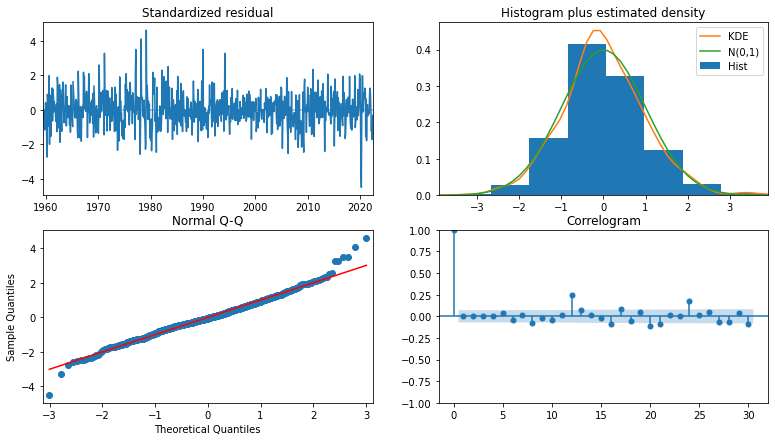

In [20]:
fig2 = model5.plot_diagnostics(lags=30, figsize=(13, 7))

### Comparing the forecasts of the above models:

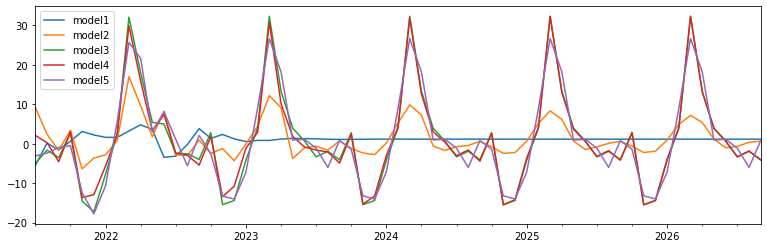

In [21]:
predictions = pd.DataFrame(
    {
        "model1": model1.predict(start=len(data_1)-12, end=len(data_1)+50),
        "model2": model2.predict(start=len(data_1)-12, end=len(data_1)+50),
        "model3": model3.predict(start=len(data_1)-12, end=len(data_1)+50),
        "model4": model4.predict(start=len(data_1)-12, end=len(data_1)+50),
        "model5": model5.predict(start=len(data_1)-12, end=len(data_1)+50),
    }
)
_, ax = plt.subplots(figsize=(13,4))
ax = predictions.plot(ax=ax)

### 2.6. AR Model with Seasonal Dynamics
When data is constantly changing over time while also showing seasonal fluctuations and interannual variability.

<AxesSubplot:xlabel='DATE'>

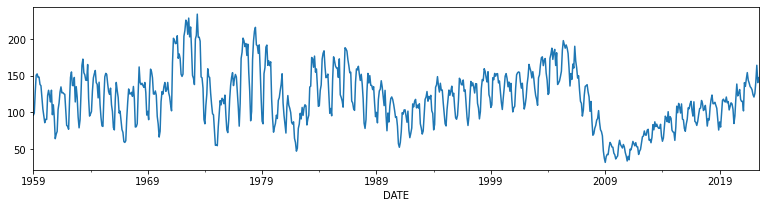

In [22]:
data_2 = data_full_1['HOUSTNSA']
# DataFrame.resample() is used for down/upsampling when dealing with a time series with datetime index.
# DataFrame.last(offset) is used to select the last few rows based on a date offset when dealing with a time series with datetime index.
data_2 = data_2.resample('MS').last()
data_2.plot(figsize=(13,3))

At first we search for the AR model order number using ar_select_order:

In [23]:
ARSO = ar_select_order(endog=data_2, maxlag=20)
print(f'Final lag numbers are {ARSO.ar_lags}')

Final lag numbers are [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17]



Here we consider seasonal dummies and reduce maxlag to 15.

In [24]:
ARSO = ar_select_order(endog=data_2, maxlag=15, glob=True, seasonal=True)
print(f'Final lag numbers by searching among the combinations of different lags are {ARSO.ar_lags}')

Final lag numbers by searching among the combinations of different lags are [1, 2, 11, 12, 14, 15]


In [25]:
model6 = ARSO.model.fit()
print(model6.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  762
Model:             Restr. Seas. AutoReg(15)   Log Likelihood               -2805.164
Method:                     Conditional MLE   S.D. of innovations             10.343
Date:                      Wed, 24 Aug 2022   AIC                           5648.328
Time:                              22:26:32   BIC                           5736.033
Sample:                          04-01-1960   HQIC                          5682.129
                               - 06-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            3.7580      2.149      1.749      0.080      -0.453       7.969
s(2,12)         -0.1319      2.217     -0.059      0.953      -4.478       4.

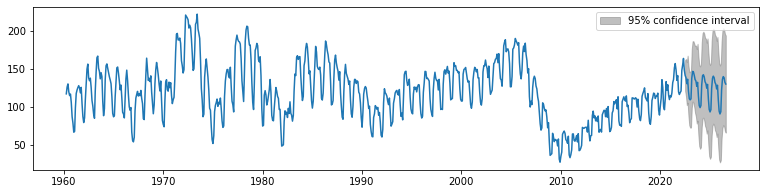

In [26]:
fig1 = model6.plot_predict(start=0, end=len(data_1)+50, figsize=(13,3))

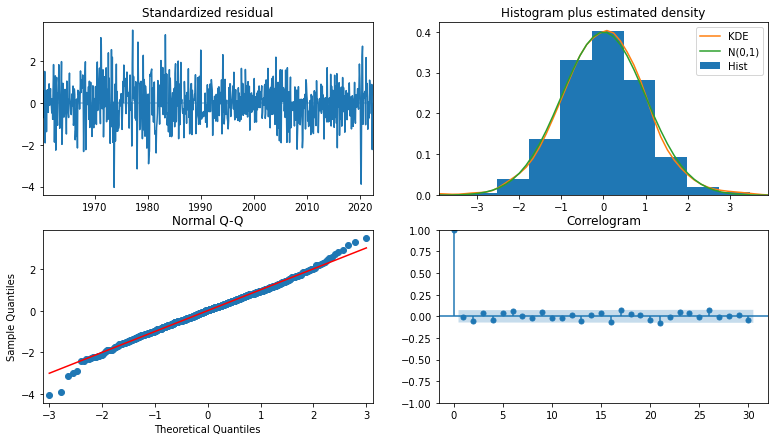

In [27]:
fig2 = model6.plot_diagnostics(lags=30, figsize=(13, 7))

We can also consider the trends in the model if there is an obvious trend. There can be constant only, time trend only, and constant and time trends. However, this may not be significant for the current data.

In [28]:
ARSO = ar_select_order(endog=data_2, maxlag=15, glob=True, seasonal=True, trend='ct')
print(f'Final lag numbers by searching among the combinations of different lags are {ARSO.ar_lags}')

Final lag numbers by searching among the combinations of different lags are [1, 2, 11, 12, 14, 15]


In [29]:
model7 = ARSO.model.fit()
print(model7.summary())

                               AutoReg Model Results                                
Dep. Variable:                     HOUSTNSA   No. Observations:                  762
Model:             Restr. Seas. AutoReg(15)   Log Likelihood               -2803.919
Method:                     Conditional MLE   S.D. of innovations             10.326
Date:                      Wed, 24 Aug 2022   AIC                           5647.838
Time:                              22:27:17   BIC                           5740.160
Sample:                          04-01-1960   HQIC                          5683.418
                               - 06-01-2022                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const            5.6655      2.462      2.301      0.021       0.840      10.491
trend           -0.0029      0.002     -1.579      0.114      -0.007       0.

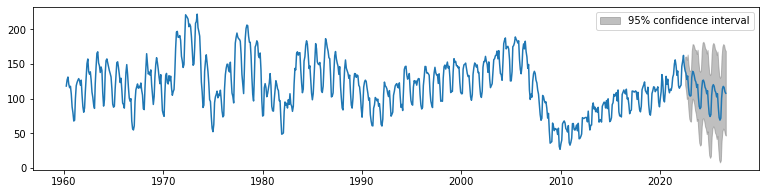

In [30]:
fig1 = model7.plot_predict(start=0, end=len(data_1)+50, figsize=(13,3))

### 2.7. Forecasting PLot
In the following, we make forecasts for the last 24 data points of 'data2', to validate the model, and 12 data points ahead of that. Then, the forecasts together with the actual data are plotted.

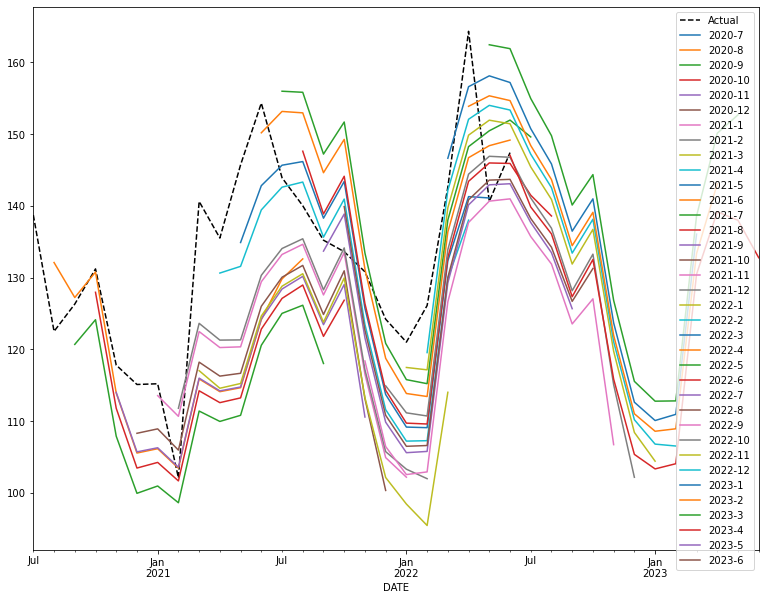

In [31]:
start_index = data_2.index[-24]
forecast_index = pd.date_range(start_index, freq=data_2.index.freq, periods=36)

# defigning the columns names for the 12 months ahead forecasts based on the first date of the forecasts
cols = ["-".join(str(val) for val in (idx.year, idx.month)) for idx in forecast_index]
forecasts = pd.DataFrame(index=forecast_index, columns=cols)

for i in range(1, 24):
    fcast = model7.predict(start=forecast_index[i], end=forecast_index[i + 12], dynamic=True)
    forecasts.loc[fcast.index, cols[i]] = fcast

_, ax = plt.subplots(figsize=(13, 10))
data_2.iloc[-24:].plot(ax=ax, color="black", linestyle="--", label='Actual')
ax = forecasts.plot(ax=ax)
plt.legend()
plt.show()

-------------
### End